# Entrainement du Modele de Segmentation

Ce notebook realise l'entrainement complet du modele U-Net sur le dataset Cityscapes.

## Objectifs
- Charger les donnees avec les generateurs
- Configurer et lancer l'entrainement
- Suivre les metriques (loss, accuracy, IoU, Dice)
- Sauvegarder le meilleur modele
- Visualiser les courbes d'apprentissage

## 1. Imports et Configuration

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping, 
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger
)
from tensorflow.keras.utils import Sequence

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# Configuration GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Memory growth active pour {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"Erreur GPU: {e}")

# Seed pour reproductibilite
tf.random.set_seed(42)
np.random.seed(42)

2026-01-31 02:24:33.969994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth active pour 1 GPU(s)


In [2]:
# Chemins
DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')
LOGS_DIR = Path('../logs')

# Creer les dossiers si necessaire
MODELS_DIR.mkdir(exist_ok=True)
LOGS_DIR.mkdir(exist_ok=True)

# Charger la configuration
with open(DATA_DIR / 'config.json', 'r') as f:
    config = json.load(f)

IMG_HEIGHT = config['img_height']
IMG_WIDTH = config['img_width']
N_CLASSES = config['n_classes']
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

print(f"Configuration chargee:")
print(f"  - Input shape: {INPUT_SHAPE}")
print(f"  - Nombre de classes: {N_CLASSES}")

Configuration chargee:
  - Input shape: (256, 512, 3)
  - Nombre de classes: 8


In [3]:
# Hyperparametres d'entrainement
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 10  # Pour early stopping

# Nom de l'experience (pour les logs)
EXPERIMENT_NAME = f"unet_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

print(f"Hyperparametres:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Patience: {PATIENCE}")
print(f"  - Experiment: {EXPERIMENT_NAME}")

Hyperparametres:
  - Batch size: 8
  - Epochs: 50
  - Learning rate: 0.0001
  - Patience: 10
  - Experiment: unet_20260131_022510


## 2. Configuration des Classes et Utilitaires

In [4]:
# Categories Cityscapes
CATEGORIES = {
    0: {'name': 'void', 'color': (0, 0, 0)},
    1: {'name': 'flat', 'color': (128, 64, 128)},
    2: {'name': 'construction', 'color': (70, 70, 70)},
    3: {'name': 'object', 'color': (153, 153, 153)},
    4: {'name': 'nature', 'color': (107, 142, 35)},
    5: {'name': 'sky', 'color': (70, 130, 180)},
    6: {'name': 'human', 'color': (220, 20, 60)},
    7: {'name': 'vehicle', 'color': (0, 0, 142)}
}

# Mapping labels -> categories
LABEL_TO_CATEGORY = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,
    7: 1, 8: 1, 9: 1, 10: 1,
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,
    17: 3, 18: 3, 19: 3, 20: 3,
    21: 4, 22: 4,
    23: 5,
    24: 6, 25: 6,
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,
}

# LUT pour conversion rapide
LUT = np.zeros(256, dtype=np.uint8)
for label_id, cat_id in LABEL_TO_CATEGORY.items():
    LUT[label_id] = cat_id

print(f"Categories: {[CATEGORIES[i]['name'] for i in range(N_CLASSES)]}")

Categories: ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']


## 3. Data Generator

In [5]:
def load_image(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Charge et preprocesse une image."""
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    return img


def load_label(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Charge et convertit un mask en 8 categories."""
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = LUT[mask]
    return mask


def mask_to_onehot(mask, n_classes=N_CLASSES):
    """Convertit un mask en one-hot."""
    return np.eye(n_classes, dtype=np.float32)[mask]


class DataAugmentation:
    """Augmentation coherente image + mask."""
    
    def __init__(self, horizontal_flip=True, brightness_range=(0.8, 1.2), 
                 contrast_range=(0.9, 1.1), rotation_range=5):
        self.horizontal_flip = horizontal_flip
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.rotation_range = rotation_range
    
    def __call__(self, image, mask):
        # Flip horizontal
        if self.horizontal_flip and np.random.random() > 0.5:
            image = np.fliplr(image)
            mask = np.fliplr(mask)
        
        # Brightness
        if self.brightness_range:
            factor = np.random.uniform(*self.brightness_range)
            image = np.clip(image * factor, 0, 1)
        
        # Contrast
        if self.contrast_range:
            factor = np.random.uniform(*self.contrast_range)
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            image = np.clip((image - mean) * factor + mean, 0, 1)
        
        return image.astype(np.float32), mask


class CityscapesGenerator(Sequence):
    """Generateur de donnees Keras pour Cityscapes."""
    
    def __init__(self, data, batch_size=8, target_size=(IMG_HEIGHT, IMG_WIDTH),
                 n_classes=N_CLASSES, augmentation=None, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.target_size = target_size
        self.n_classes = n_classes
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        batch_images = []
        batch_masks = []
        
        for idx in batch_indexes:
            sample = self.data[idx]
            
            image = load_image(sample['image'], self.target_size)
            mask = load_label(sample['label'], self.target_size)
            
            if self.augmentation:
                image, mask = self.augmentation(image, mask)
            
            batch_images.append(image)
            batch_masks.append(mask_to_onehot(mask, self.n_classes))
        
        return np.array(batch_images), np.array(batch_masks)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

print("Data generator defini")

Data generator defini


In [6]:
# Charger les chemins des donnees
train_df = pd.read_csv(DATA_DIR / 'train_paths.csv')
val_df = pd.read_csv(DATA_DIR / 'val_paths.csv')

train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')

print(f"Train: {len(train_data)} images")
print(f"Val: {len(val_data)} images")

Train: 2975 images
Val: 500 images


In [7]:
# Creer les generateurs
train_augmentation = DataAugmentation(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    contrast_range=(0.9, 1.1)
)

train_generator = CityscapesGenerator(
    train_data,
    batch_size=BATCH_SIZE,
    augmentation=train_augmentation,
    shuffle=True
)

val_generator = CityscapesGenerator(
    val_data,
    batch_size=BATCH_SIZE,
    augmentation=None,
    shuffle=False
)

print(f"Train batches: {len(train_generator)}")
print(f"Val batches: {len(val_generator)}")

# Verifier un batch
X_batch, y_batch = train_generator[0]
print(f"\nBatch shapes: X={X_batch.shape}, y={y_batch.shape}")

Train batches: 372
Val batches: 63

Batch shapes: X=(8, 256, 512, 3), y=(8, 256, 512, 8)


## 4. Definition du Modele

In [8]:
def conv_block(inputs, n_filters, kernel_size=3, batch_norm=True):
    """Bloc de convolution double."""
    x = layers.Conv2D(n_filters, kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def encoder_block(inputs, n_filters, dropout_rate=0.3):
    """Bloc encodeur."""
    skip = conv_block(inputs, n_filters)
    pool = layers.MaxPooling2D((2, 2))(skip)
    pool = layers.Dropout(dropout_rate)(pool)
    return skip, pool


def decoder_block(inputs, skip, n_filters, dropout_rate=0.3):
    """Bloc decodeur."""
    x = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = layers.Concatenate()([x, skip])
    x = layers.Dropout(dropout_rate)(x)
    x = conv_block(x, n_filters)
    return x


def build_unet(input_shape, n_classes, filters=[32, 64, 128, 256, 512]):
    """Construit un modele U-Net."""
    inputs = layers.Input(shape=input_shape)
    
    # Encodeur
    skip1, pool1 = encoder_block(inputs, filters[0])
    skip2, pool2 = encoder_block(pool1, filters[1])
    skip3, pool3 = encoder_block(pool2, filters[2])
    skip4, pool4 = encoder_block(pool3, filters[3])
    
    # Bottleneck
    bottleneck = conv_block(pool4, filters[4])
    
    # Decodeur
    dec4 = decoder_block(bottleneck, skip4, filters[3])
    dec3 = decoder_block(dec4, skip3, filters[2])
    dec2 = decoder_block(dec3, skip2, filters[1])
    dec1 = decoder_block(dec2, skip1, filters[0])
    
    # Sortie
    outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(dec1)
    
    return Model(inputs, outputs, name='UNet')

print("Architecture U-Net definie")

Architecture U-Net definie


In [9]:
# Creer le modele
model = build_unet(INPUT_SHAPE, N_CLASSES)

print(f"Modele: {model.name}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Parametres: {model.count_params():,}")

I0000 00:00:1769822711.971927    1336 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.9


Modele: UNet
Input shape: (None, 256, 512, 3)
Output shape: (None, 256, 512, 8)
Parametres: 7,772,104


## 5. Fonctions de Perte et Metriques

In [10]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Coefficient de Dice."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )


def dice_loss(y_true, y_pred):
    """Dice Loss."""
    return 1 - dice_coefficient(y_true, y_pred)


def combined_loss(y_true, y_pred):
    """Categorical Cross-Entropy + Dice Loss."""
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return cce + dice


class MeanIoU(tf.keras.metrics.Metric):
    """Mean Intersection over Union."""
    
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        
        iou_per_class = []
        for c in range(self.num_classes):
            true_c = tf.cast(tf.equal(y_true_labels, c), tf.float32)
            pred_c = tf.cast(tf.equal(y_pred_labels, c), tf.float32)
            intersection = tf.reduce_sum(true_c * pred_c)
            union = tf.reduce_sum(true_c) + tf.reduce_sum(pred_c) - intersection
            iou = tf.where(union > 0, intersection / union, 0.0)
            iou_per_class.append(iou)
        
        mean_iou = tf.reduce_mean(tf.stack(iou_per_class))
        self.total_iou.assign_add(mean_iou)
        self.count.assign_add(1.0)
    
    def result(self):
        return self.total_iou / self.count
    
    def reset_state(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

print("Loss et metriques definies")

Loss et metriques definies


## 6. Compilation du Modele

In [11]:
# Compiler le modele
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=combined_loss,
    metrics=[
        'accuracy',
        dice_coefficient,
        MeanIoU(num_classes=N_CLASSES)
    ]
)

print("Modele compile avec:")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  - Loss: Combined (CCE + Dice)")
print(f"  - Metriques: accuracy, dice, mIoU")

Modele compile avec:
  - Optimizer: Adam (lr=0.0001)
  - Loss: Combined (CCE + Dice)
  - Metriques: accuracy, dice, mIoU


## 7. Configuration des Callbacks

In [12]:
# Dossier pour cette experience
exp_dir = LOGS_DIR / EXPERIMENT_NAME
exp_dir.mkdir(exist_ok=True)

callbacks = [
    # Sauvegarder le meilleur modele
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'unet_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    # Sauvegarder a chaque epoch
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'unet_latest.keras'),
        monitor='val_loss',
        save_best_only=False,
        verbose=0
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduire le learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=PATIENCE // 2,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard
    TensorBoard(
        log_dir=str(exp_dir),
        histogram_freq=1,
        write_graph=True
    ),
    
    # CSV Logger
    CSVLogger(
        filename=str(exp_dir / 'training_log.csv'),
        separator=',',
        append=False
    )
]

print(f"Callbacks configures:")
print(f"  - ModelCheckpoint (best + latest)")
print(f"  - EarlyStopping (patience={PATIENCE})")
print(f"  - ReduceLROnPlateau")
print(f"  - TensorBoard (logs: {exp_dir})")
print(f"  - CSVLogger")

Callbacks configures:
  - ModelCheckpoint (best + latest)
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau
  - TensorBoard (logs: ../logs/unet_20260131_022510)
  - CSVLogger


## 8. Entrainement

In [13]:
# Sauvegarder la configuration de l'experience
experiment_config = {
    'experiment_name': EXPERIMENT_NAME,
    'model': 'UNet',
    'input_shape': INPUT_SHAPE,
    'n_classes': N_CLASSES,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'patience': PATIENCE,
    'loss': 'combined_loss',
    'optimizer': 'Adam',
    'train_samples': len(train_data),
    'val_samples': len(val_data),
    'augmentation': {
        'horizontal_flip': True,
        'brightness_range': [0.8, 1.2],
        'contrast_range': [0.9, 1.1]
    }
}

with open(exp_dir / 'config.json', 'w') as f:
    json.dump(experiment_config, f, indent=2)

print("Configuration de l'experience sauvegardee")

Configuration de l'experience sauvegardee


In [14]:
print("="*60)
print("DEBUT DE L'ENTRAINEMENT")
print("="*60)
print(f"\nExperience: {EXPERIMENT_NAME}")
print(f"Train: {len(train_data)} images ({len(train_generator)} batches)")
print(f"Val: {len(val_data)} images ({len(val_generator)} batches)")
print(f"\nLancement...\n")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("ENTRAINEMENT TERMINE")
print("="*60)

DEBUT DE L'ENTRAINEMENT

Experience: unet_20260131_022510
Train: 2975 images (372 batches)
Val: 500 images (63 batches)

Lancement...



/mnt/c/Users/Thomas/Documents/Code/openclassrooms/openclassrooms-projet8/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2026-01-31 02:25:23.934066: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e94604422e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-31 02:25:23.934102: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-01-31 02:25:24.234931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-31 02:25:25.650942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-31 02:25:28.215078: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory a

134/372 ━━━━━━━━━━━━━━━━━━━━ 5:27 1s/step - accuracy: 0.3727 - dice_coefficient: 0.2183 - loss: 2.6356 - mean_iou: 0.1531

2026-01-31 02:28:59.623920: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-31 02:29:00.002031: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5316 - dice_coefficient: 0.3363 - loss: 2.1629 - mean_iou: 0.2446
Epoch 1: val_loss improved from None to 1.74420, saving model to ../models/unet_best.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.6789 - dice_coefficient: 0.4727 - loss: 1.6593 - mean_iou: 0.3473 - val_accuracy: 0.6353 - val_dice_coefficient: 0.5443 - val_loss: 1.7442 - val_mean_iou: 0.3007 - learning_rate: 1.0000e-04
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8179 - dice_coefficient: 0.6706 - loss: 1.0254 - mean_iou: 0.4947
Epoch 2: val_loss improved from 1.74420 to 0.99486, saving model to ../models/unet_best.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.8240 - dice_coefficient: 0.6926 - loss: 0.9696 - mean_iou: 0.5040 - val_accuracy: 0.8015 - val_dice_coefficient: 0.7323 - val_loss: 0.9949 - val_mean_iou: 0.4655 - learning_rate: 1.0000e-04
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8395 - 

## 9. Visualisation des Resultats

Figure sauvegardee: ../logs/unet_20260131_022510/training_curves.png


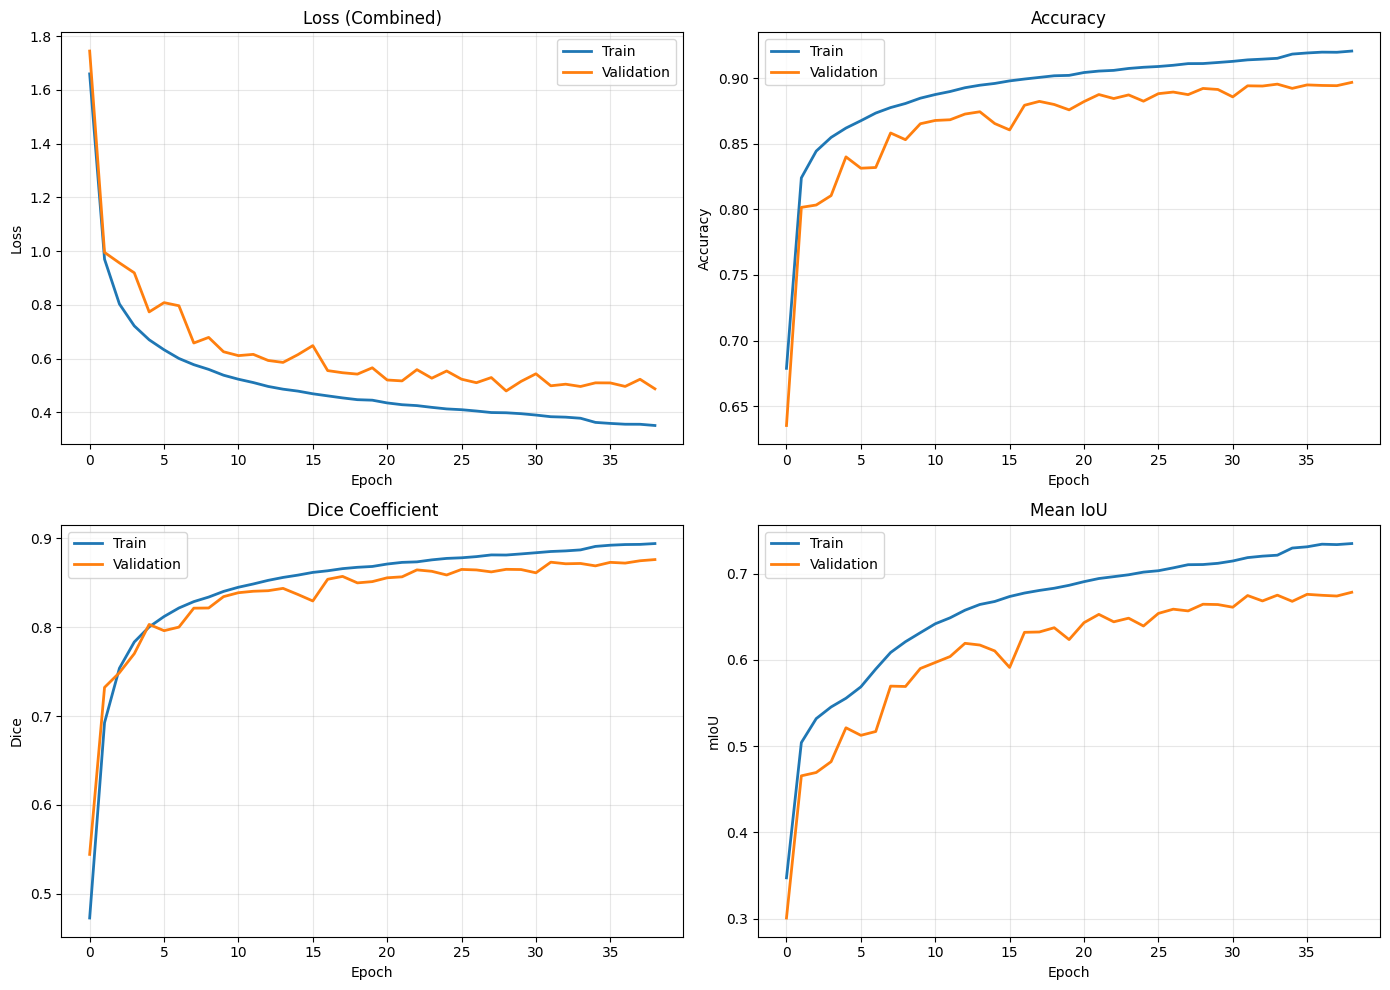

In [15]:
def plot_training_history(history, save_path=None):
    """Visualise les courbes d'apprentissage."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Loss (Combined)', fontsize=12)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=12)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Dice coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Dice Coefficient', fontsize=12)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean IoU
    axes[1, 1].plot(history.history['mean_iou'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_mean_iou'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Mean IoU', fontsize=12)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('mIoU')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure sauvegardee: {save_path}")
    
    plt.show()

# Visualiser
plot_training_history(history, save_path=exp_dir / 'training_curves.png')

In [16]:
# Resume des resultats
print("\n" + "="*60)
print("RESUME DES RESULTATS")
print("="*60)

# Meilleurs scores
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nMeilleur epoch: {best_epoch + 1}")
print(f"\nScores sur validation:")
print(f"  - Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"  - Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"  - Dice: {history.history['val_dice_coefficient'][best_epoch]:.4f}")
print(f"  - mIoU: {history.history['val_mean_iou'][best_epoch]:.4f}")

print(f"\nScores finaux:")
print(f"  - Loss: {history.history['val_loss'][-1]:.4f}")
print(f"  - Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  - Dice: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"  - mIoU: {history.history['val_mean_iou'][-1]:.4f}")


RESUME DES RESULTATS

Meilleur epoch: 29

Scores sur validation:
  - Loss: 0.4794
  - Accuracy: 0.8921
  - Dice: 0.8653
  - mIoU: 0.6644

Scores finaux:
  - Loss: 0.4872
  - Accuracy: 0.8967
  - Dice: 0.8763
  - mIoU: 0.6782


## 10. Predictions sur Validation

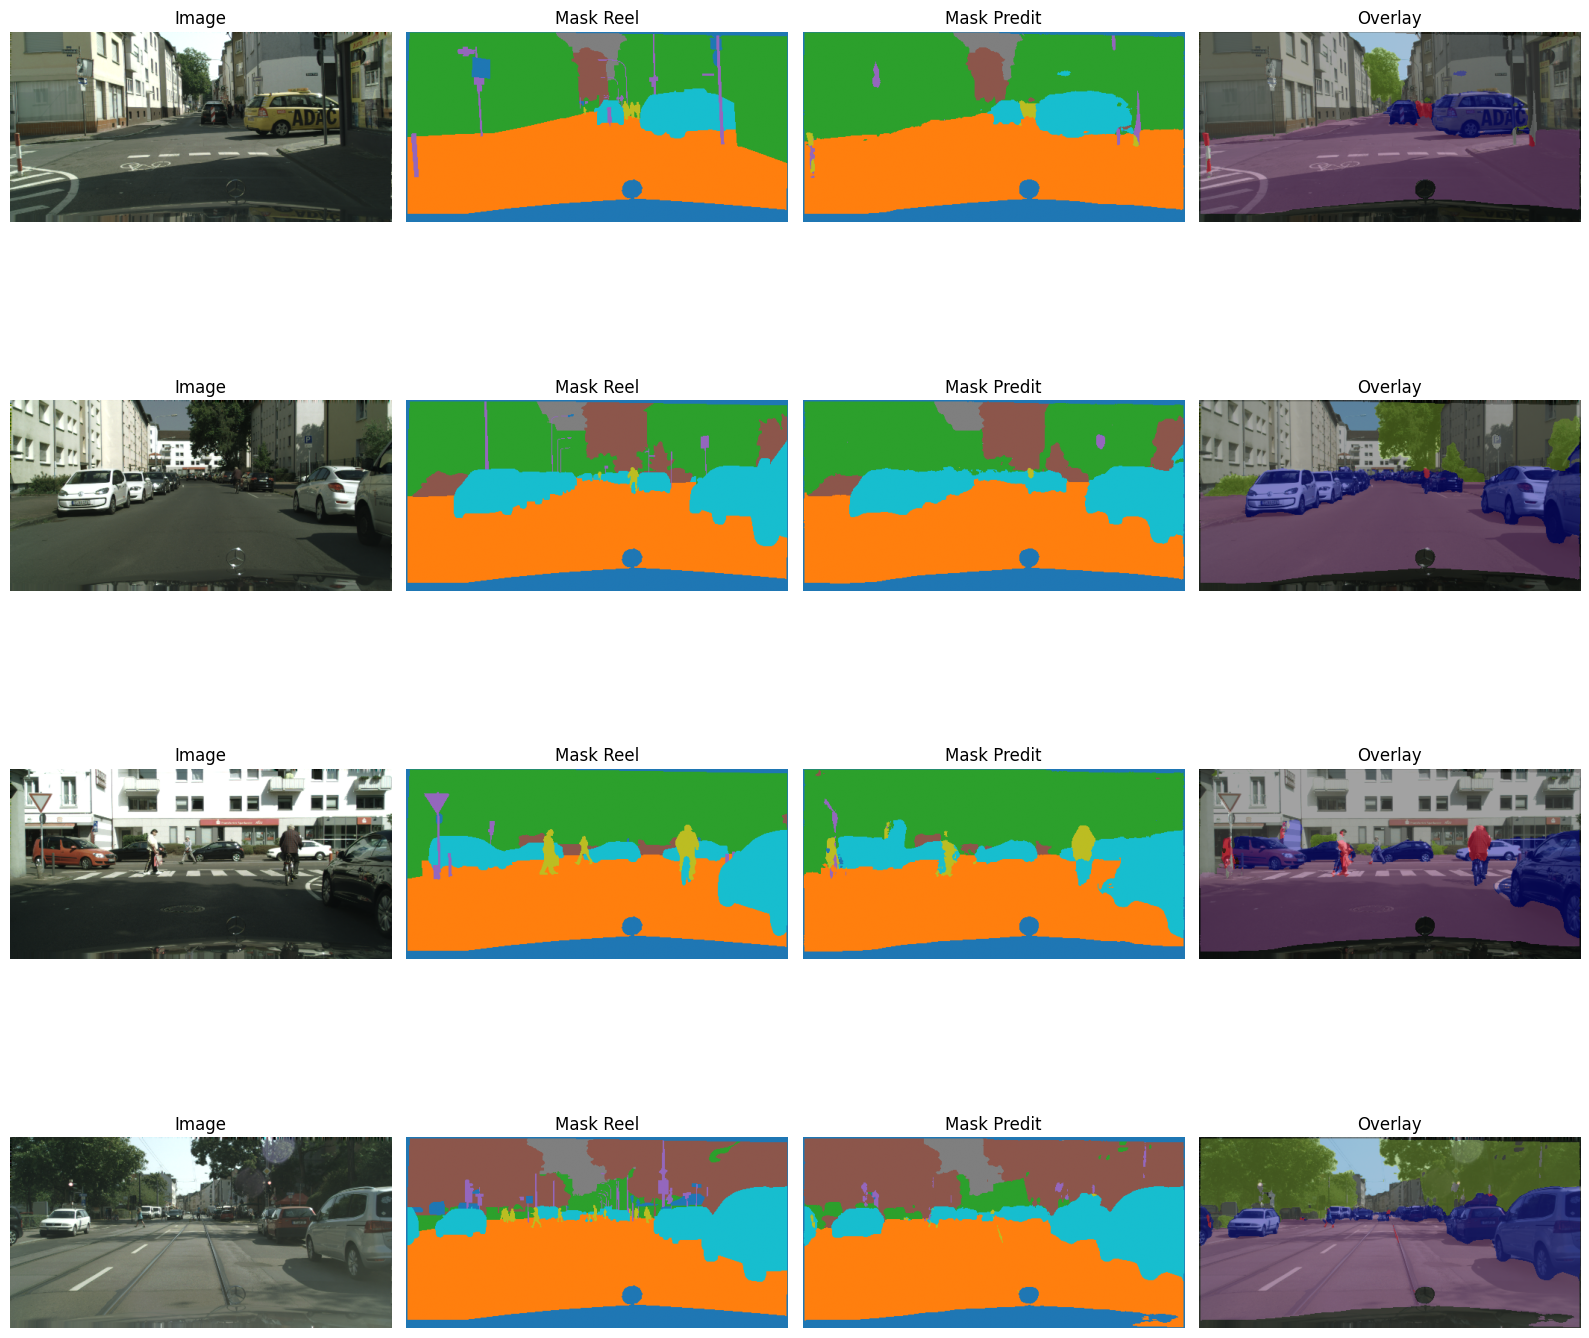

In [17]:
def visualize_predictions(model, generator, n_samples=4):
    """Visualise des predictions du modele."""
    X, y_true = generator[0]
    y_pred = model.predict(X[:n_samples], verbose=0)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    
    for i in range(n_samples):
        # Image originale
        axes[i, 0].imshow(X[i])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        
        # Mask reel
        true_mask = np.argmax(y_true[i], axis=-1)
        axes[i, 1].imshow(true_mask, cmap='tab10', vmin=0, vmax=N_CLASSES-1)
        axes[i, 1].set_title('Mask Reel')
        axes[i, 1].axis('off')
        
        # Mask predit
        pred_mask = np.argmax(y_pred[i], axis=-1)
        axes[i, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=N_CLASSES-1)
        axes[i, 2].set_title('Mask Predit')
        axes[i, 2].axis('off')
        
        # Overlay prediction sur image
        overlay = X[i].copy()
        for cat_id, info in CATEGORIES.items():
            mask_cat = pred_mask == cat_id
            overlay[mask_cat] = overlay[mask_cat] * 0.5 + np.array(info['color'])/255.0 * 0.5
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig(exp_dir / 'predictions_sample.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(model, val_generator, n_samples=4)

## 11. Sauvegarde Finale

In [18]:
# Sauvegarder l'historique d'entrainement
history_df = pd.DataFrame(history.history)
history_df.to_csv(exp_dir / 'history.csv', index=False)
print(f"Historique sauvegarde: {exp_dir / 'history.csv'}")

# Sauvegarder le modele final
model.save(MODELS_DIR / 'unet_final.keras')
print(f"Modele final sauvegarde: {MODELS_DIR / 'unet_final.keras'}")

# Resume des fichiers crees
print(f"\nFichiers crees:")
print(f"  - {MODELS_DIR / 'unet_best.keras'}")
print(f"  - {MODELS_DIR / 'unet_final.keras'}")
print(f"  - {exp_dir / 'training_log.csv'}")
print(f"  - {exp_dir / 'history.csv'}")
print(f"  - {exp_dir / 'training_curves.png'}")
print(f"  - {exp_dir / 'predictions_sample.png'}")
print(f"  - {exp_dir / 'config.json'}")

Historique sauvegarde: ../logs/unet_20260131_022510/history.csv
Modele final sauvegarde: ../models/unet_final.keras

Fichiers crees:
  - ../models/unet_best.keras
  - ../models/unet_final.keras
  - ../logs/unet_20260131_022510/training_log.csv
  - ../logs/unet_20260131_022510/history.csv
  - ../logs/unet_20260131_022510/training_curves.png
  - ../logs/unet_20260131_022510/predictions_sample.png
  - ../logs/unet_20260131_022510/config.json


In [19]:
print("\n" + "="*60)
print("ENTRAINEMENT COMPLETE")
print("="*60)
print(f"\nModele: {model.name}")
print(f"Parametres: {model.count_params():,}")
print(f"\nMeilleurs scores (validation):")
print(f"  - Dice: {max(history.history['val_dice_coefficient']):.4f}")
print(f"  - mIoU: {max(history.history['val_mean_iou']):.4f}")
print(f"\nProchaine etape: Notebook 05 - Evaluation")


ENTRAINEMENT COMPLETE

Modele: UNet
Parametres: 7,772,104

Meilleurs scores (validation):
  - Dice: 0.8763
  - mIoU: 0.6782

Prochaine etape: Notebook 05 - Evaluation


## Notes pour ameliorer les resultats

1. **Augmenter les epochs** si le modele continue a s'ameliorer
2. **Utiliser un backbone pre-entraine** (VGG16, ResNet) pour de meilleurs resultats
3. **Augmentation plus agressive** (rotation, zoom, etc.)
4. **Ajuster le learning rate** avec un scheduler
5. **Utiliser une taille d'image plus grande** si la memoire le permet